In [ ]:
import torch
import copy
import torchvision
import numpy as np
import random
import os
from tqdm import tqdm
from torchvision import transforms as T
from torchvision import models
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch.optim as optim
from google.colab import drive

In [ ]:
# ONLY AVAILABLE IF WORKING INSIDE GOOGLE COLAB
# IF NOT WORKING INSIDE GOOGLE COLAB, PLEASE IGNORE THIS CELL
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/CAPSTONE/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi -L 

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-a54cbe57-29c2-4151-7179-f92af8756715)


In [ ]:
# dir(models)
# tried previously: mobilenet_v2, vgg16, resnet56_noshort
MODEL_IDENTIFIER = 'resnet110_noshort'
# previous optimizer names: SGD, Adam
OPTIMIZER_NAME= 'SGD'
DATASET_NAME = 'cifar10'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# LOAD MODEL FROM TORCH: model = torch.hub.load('pytorch/vision:v0.6.0', MODEL_IDENTIFIER, weights = None, verbose=False)
# from cifar10_models.vgg import VGG
from cifar10_models.resnet import ResNet56_noshort
from cifar10_models.resnet import ResNet110_noshort

In [ ]:
# model = VGG()
model = ResNet110_noshort()

In [ ]:
model.to(device)

ResNet_cifar(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock_noshortcut(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock_noshortcut(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
PATH_TO_DATASET = "./data"

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = CIFAR10(root='./data', 
                   train=True,
                   download=True, 
                   transform=transform_train)

testset = CIFAR10(root='./data', 
                  train=False,
                  download=True, 
                  transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset_size = len(dataset)
print("Dateset Size: ", dataset_size)
classes = dataset.classes
print("Classes: ", classes[0:10])

Dateset Size:  50000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
img, label = dataset[1]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog
<class 'torch.Tensor'>
torch.Size([3, 32, 32])


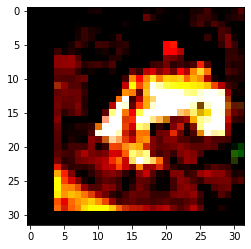

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print(type(img))
print(img.size())

In [ ]:
# We set the seed at the beginning of each experiment to ensure reproducibility.
# We also make sure no non-deterministic methods are used.

def setup_seed(s):
  torch.manual_seed(s)
  random.seed(s)
  np.random.seed(s)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
SEED = 1234

In [ ]:
setup_seed(SEED)

In [ ]:
# We preserve reproducibility in data loading:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32

In [ ]:
g = torch.Generator()
g.manual_seed(SEED)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=4, 
                                           worker_init_fn=seed_worker, 
                                           generator=g)

In [ ]:
N_EPOCHS = 100 # previously 100
LR = 0.05
MOMENTUM = 0.9
# WEIGHT_DECAY = 0
WEIGHT_DECAY = 0
BETAS = (0.9, 0.999) # default beta values for the Adam Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# optimizer = optim.Adam(model.parameters(), lr=LR, betas=BETAS, weight_decay = WEIGHT_DECAY)

In [ ]:
SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}.pt'
#SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}.pt'
print(SAVED_MODEL_NAME)

cifar10_resnet110_noshort_SGD_epochs=100_BS=128_LR=0.05_MOM=0.9_WD=0.pt


In [ ]:
PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}'
#PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}'
print(PARTIAL_NAME)

cifar10_resnet110_noshort_SGD_epochs=100_BS=128_LR=0.05_MOM=0.9_WD=0


In [ ]:
# TRAINING THE DEEP LEARNING MODEL
train_losses, accuracies = [], []
for epoch in range(N_EPOCHS):
  running_loss = 0
  correct = 0
  total = 0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  accuracy = 100 * correct / total
  accuracies.append(accuracy)
  print(f'Train Loss : {train_loss} ;   Accuracy : {accuracy}%')

torch.save(model, SAVED_MODEL_NAME)

100%|██████████| 391/391 [00:39<00:00,  9.79it/s]


Train Loss : 2.3060751625948854 ;   Accuracy : 10.188%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.3036622391332444 ;   Accuracy : 9.93%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.30330352100265 ;   Accuracy : 9.786%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.3029424034421098 ;   Accuracy : 10.242%


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


Train Loss : 2.3034399348451657 ;   Accuracy : 9.912%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.3031709303941263 ;   Accuracy : 10.032%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.302953305451766 ;   Accuracy : 10.268%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.303105645167553 ;   Accuracy : 10.108%


100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


Train Loss : 2.3034211729493594 ;   Accuracy : 9.902%


100%|██████████| 391/391 [00:39<00:00,  9.83it/s]


Train Loss : 2.3034331377814796 ;   Accuracy : 10.056%


100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


Train Loss : 2.3030798453504167 ;   Accuracy : 10.146%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.3031810348296102 ;   Accuracy : 9.988%


100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Train Loss : 2.3032340405847105 ;   Accuracy : 10.054%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.3035356285017166 ;   Accuracy : 9.84%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.303021518165803 ;   Accuracy : 9.766%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.3031113470911673 ;   Accuracy : 10.25%


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Train Loss : 2.3032667185644358 ;   Accuracy : 9.756%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.3030844521339593 ;   Accuracy : 10.124%


100%|██████████| 391/391 [00:40<00:00,  9.73it/s]


Train Loss : 2.3030554028728125 ;   Accuracy : 10.082%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.3030973371032557 ;   Accuracy : 9.864%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.302858513639406 ;   Accuracy : 10.026%


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


Train Loss : 2.303267004544778 ;   Accuracy : 9.996%


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss : 2.3030537144302405 ;   Accuracy : 9.996%


100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Train Loss : 2.303103371959208 ;   Accuracy : 10.006%


100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


Train Loss : 2.303141980524868 ;   Accuracy : 10.05%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.3031344474733944 ;   Accuracy : 9.998%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.303027704853536 ;   Accuracy : 9.874%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.3033364703283286 ;   Accuracy : 9.974%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.3031726401785146 ;   Accuracy : 9.836%


100%|██████████| 391/391 [00:39<00:00,  9.83it/s]


Train Loss : 2.3027929070660527 ;   Accuracy : 10.068%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.3032379510152676 ;   Accuracy : 9.982%


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Train Loss : 2.303270058863608 ;   Accuracy : 10.014%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.3030215169462704 ;   Accuracy : 10.152%


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Train Loss : 2.303012650336146 ;   Accuracy : 10.028%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.3033422856684536 ;   Accuracy : 9.998%


100%|██████████| 391/391 [00:39<00:00,  9.79it/s]


Train Loss : 2.303320225547342 ;   Accuracy : 10.128%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.3030775904350573 ;   Accuracy : 10.134%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.30309475535322 ;   Accuracy : 9.872%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.3027896692075998 ;   Accuracy : 10.008%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.3021314064864917 ;   Accuracy : 10.148%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.3025463432302256 ;   Accuracy : 10.16%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.30212950218669 ;   Accuracy : 10.286%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.302334424479843 ;   Accuracy : 10.3%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.2991415405517346 ;   Accuracy : 10.952%


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss : 2.293231713497425 ;   Accuracy : 11.404%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.282311810861768 ;   Accuracy : 12.384%


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Train Loss : 2.2653263328630295 ;   Accuracy : 13.288%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.256233036060772 ;   Accuracy : 13.642%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.2510599730264804 ;   Accuracy : 13.73%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.2461545644208902 ;   Accuracy : 14.034%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.2437077373494883 ;   Accuracy : 13.968%


100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Train Loss : 2.2436154150901855 ;   Accuracy : 14.17%


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss : 2.2420435866431507 ;   Accuracy : 14.098%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.2388412062164464 ;   Accuracy : 14.222%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.236124227723807 ;   Accuracy : 14.346%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.235962497608741 ;   Accuracy : 14.31%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.232177930719712 ;   Accuracy : 14.578%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.233544750286795 ;   Accuracy : 14.27%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.2292372851115663 ;   Accuracy : 14.844%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.230661336723191 ;   Accuracy : 14.53%


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


Train Loss : 2.230069327537361 ;   Accuracy : 14.422%


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Train Loss : 2.2267283631102814 ;   Accuracy : 14.81%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.2256877556481323 ;   Accuracy : 14.71%


100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


Train Loss : 2.22514728938832 ;   Accuracy : 14.854%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.221920454898454 ;   Accuracy : 15.044%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.218621974710918 ;   Accuracy : 15.662%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.215367848915822 ;   Accuracy : 15.93%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.2121311545067126 ;   Accuracy : 16.458%


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss : 2.210172237947469 ;   Accuracy : 16.462%


100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


Train Loss : 2.208505352439783 ;   Accuracy : 16.332%


100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Train Loss : 2.2071218325963717 ;   Accuracy : 16.546%


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Train Loss : 2.205555124965775 ;   Accuracy : 16.46%


100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


Train Loss : 2.204928185323925 ;   Accuracy : 16.564%


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


Train Loss : 2.202277806713758 ;   Accuracy : 16.77%


100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


Train Loss : 2.2008597155666108 ;   Accuracy : 16.886%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.200889734965761 ;   Accuracy : 16.85%


100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


Train Loss : 2.198031050469869 ;   Accuracy : 17.02%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.1983592113875368 ;   Accuracy : 17.158%


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Train Loss : 2.200403964732919 ;   Accuracy : 16.83%


100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Train Loss : 2.1983564668299294 ;   Accuracy : 16.98%


100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


Train Loss : 2.198019899065842 ;   Accuracy : 16.932%


100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


Train Loss : 2.1972867058366155 ;   Accuracy : 16.998%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.192380751490288 ;   Accuracy : 17.24%


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


Train Loss : 2.1946109487577474 ;   Accuracy : 17.384%


100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


Train Loss : 2.191193193425913 ;   Accuracy : 17.182%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.188697182004104 ;   Accuracy : 17.428%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.1930948669648234 ;   Accuracy : 17.23%


100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


Train Loss : 2.193200132730977 ;   Accuracy : 17.316%


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Train Loss : 2.191563169059851 ;   Accuracy : 17.546%


100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


Train Loss : 2.190016214195115 ;   Accuracy : 17.236%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Train Loss : 2.192259417165576 ;   Accuracy : 17.298%


100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


Train Loss : 2.1897689052250073 ;   Accuracy : 17.45%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.186585699505818 ;   Accuracy : 17.66%


100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Train Loss : 2.1884301995377404 ;   Accuracy : 17.5%


100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


Train Loss : 2.188536489711088 ;   Accuracy : 17.45%


100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


Train Loss : 2.1876863030826343 ;   Accuracy : 17.36%


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Train Loss : 2.1851161007990925 ;   Accuracy : 17.7%


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


Train Loss : 2.184702636030934 ;   Accuracy : 17.752%


100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


Train Loss : 2.1880189220008948 ;   Accuracy : 17.674%


100%|██████████| 391/391 [00:39<00:00,  9.99it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Train Loss : 2.184663287818889 ;   Accuracy : 17.87%
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-1304ba007241>", line 25, in <module>
    torch.save(model, SAVED_MODEL_NAME)
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 422, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 309, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 287, in __init__
    super(_open_zipfile_writer_file, self).__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File cifar10_resnet110_noshort_SGD_epochs=100_BS=128_LR=0.05_MOM=0.9_WD=0.pt cannot be opened.

During handling of the above exception, another exception occurred:

T

RuntimeError: ignored

In [ ]:
train_losses = np.array(train_losses)
accuracies = np.array(accuracies)
np.save("TRAIN_LOSSES_" + PARTIAL_NAME, train_losses)
np.save("TRAIN_ACCURACIES_" + PARTIAL_NAME, accuracies)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-95-a143c06393a0>", line 3, in <module>
    np.save("TRAIN_LOSSES_" + PARTIAL_NAME, train_losses)
  File "<__array_function__ internals>", line 180, in save
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 515, in save
    file_ctx = open(file, "wb")
OSError: [Errno 107] Transport endpoint is not connected: 'TRAIN_LOSSES_cifar10_resnet110_noshort_SGD_epochs=100_BS=128_LR=0.05_MOM=0.9_WD=0.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception,

OSError: ignored

In [ ]:
MDL = torch.load(SAVED_MODEL_NAME).eval()
MDL = MDL.to(device)

In [ ]:
# EVALUATE THE ACCURACY OF THE SAVED MODEL
correct = 0
total = 0
for inputs, labels in tqdm(train_loader):
  inputs, labels = inputs.to('cuda'), labels.to('cuda')
  outputs = MDL(inputs)
  correct += (outputs.argmax(axis=1)==labels).sum().item()
  total += labels.size(0)
  # del MDL, inputs, labels
  torch.cuda.empty_cache()
  
accuracy = 100. * correct / total
print('Train Accuracy: %.2f \n'%accuracy)

100%|██████████| 391/391 [00:22<00:00, 17.31it/s]

Train Accuracy: 17.55 



In [ ]:
def init_directions(model, seed):
  torch.manual_seed(seed)
  noises = []
  n_params = 0
  for name, param in model.named_parameters():
      delta = torch.normal(.0, 1., size=param.size())
      nu = torch.normal(.0, 1., size=param.size())

      param_norm = torch.norm(param)
      delta_norm = torch.norm(delta)
      nu_norm = torch.norm(nu)

      delta /= delta_norm
      delta *= param_norm

      nu /= nu_norm
      nu *= param_norm

      noises.append((delta, nu))

      n_params += np.prod(param.size())

  print(f'A total of {n_params:,} parameters.')

  return noises


def init_network(model, all_noises, alpha, beta):
  with torch.no_grad():
    for param, noises in zip(model.parameters(), all_noises):
      delta, nu = noises
      new_value = param + alpha * delta + beta * nu
      param.copy_(new_value)
  return model


In [ ]:
def load_model (model_name):
  return torch.load(model_name, map_location=torch.device('cpu')) #.eval()

In [ ]:
def run_landscape_gen(model_name, dataloader, resolution, seed):

    print(f'Testing {model_name}')

    noises = init_directions(load_model(model_name), seed)

    crit = torch.nn.CrossEntropyLoss()

    A, B = np.meshgrid(np.linspace(-1, 1, resolution),
                       np.linspace(-1, 1, resolution), 
                       indexing='ij')
    
    # SAVE X AND Y VALUES
    np.save("XX_" + PARTIAL_NAME + ".npy", A)
    np.save("YY_" + PARTIAL_NAME + ".npy", B)
    
    ZZ_filename = "ZZ_" + PARTIAL_NAME + ".npy"
    # CHECK IF FILE ALREADY EXISTS AND START FROM THERE
    if os.path.exists(ZZ_filename):
      partial_array = np.load(ZZ_filename)
      resume_index = int(np.where(~partial_array.any(axis=1))[0][0])
      loss_surface = partial_array
    else:
      resume_index = 0
      loss_surface = np.zeros_like(A)

    
    print(f"Resuming Computation from Index {resume_index}\n")
    for i in range(resume_index, resolution):
        for j in range(resolution):
            total_loss = 0.
            n_batch = 0
            alpha = A[i, j]
            beta = B[i, j]
            net = init_network(load_model(model_name), noises, alpha, beta).to('cuda')
            torch.autograd.set_detect_anomaly(True)
            for batch, labels in dataloader:
                batch = batch.to('cuda')
                labels = labels.to('cuda')
                with torch.no_grad():
                    preds = net(batch)
                    loss = crit(preds, labels)
                    total_loss += loss.item()
                    n_batch += 1
            loss_surface[i, j] = total_loss / n_batch
            del net, batch, labels
            print(f'alpha : {alpha:.2f}, beta : {beta:.2f}, loss : {loss_surface[i, j]:.2f}')
            torch.cuda.empty_cache()
        # save computed losses so far
        np.save(ZZ_filename, loss_surface)

In [ ]:
run_landscape_gen(model_name=SAVED_MODEL_NAME, 
                  dataloader=train_loader,
                  resolution=30,
                  seed=1234)

Testing cifar10_resnet110_noshort_SGD_epochs=100_BS=128_LR=0.05_MOM=0.9_WD=0.pt
A total of 1,727,962 parameters.
Resuming Computation from Index 0

alpha : -1.00, beta : -1.00, loss : 2.75
alpha : -1.00, beta : -0.93, loss : 2.72
alpha : -1.00, beta : -0.86, loss : 2.71
alpha : -1.00, beta : -0.79, loss : 2.71
alpha : -1.00, beta : -0.72, loss : 2.68
alpha : -1.00, beta : -0.66, loss : 2.67
alpha : -1.00, beta : -0.59, loss : 2.65
alpha : -1.00, beta : -0.52, loss : 2.62
alpha : -1.00, beta : -0.45, loss : 2.58
alpha : -1.00, beta : -0.38, loss : 2.55
alpha : -1.00, beta : -0.31, loss : 2.52
alpha : -1.00, beta : -0.24, loss : 2.51
alpha : -1.00, beta : -0.17, loss : 2.50
alpha : -1.00, beta : -0.10, loss : 2.48
alpha : -1.00, beta : -0.03, loss : 2.46
alpha : -1.00, beta : 0.03, loss : 2.45
alpha : -1.00, beta : 0.10, loss : 2.45
alpha : -1.00, beta : 0.17, loss : 2.46
alpha : -1.00, beta : 0.24, loss : 2.45
alpha : -1.00, beta : 0.31, loss : 2.42
alpha : -1.00, beta : 0.38, loss : 2.

In [ ]:
# parser = argparse.ArgumentParser(description='Arguments to generate loss landscape.')
# parser.add_argument('--path_to_imagenetv2', default='/mnt/storage/datasets/imagenetv2-top-images-format-val/', type=str)
# parser.add_argument('--batch_size', default=8, type=int)
# parser.add_argument('--resolution', default=25, type=int)

# plt.figure(figsize=(18, 12))
# plt.contour(A, B, loss_surface)
# plt.savefig(f'{model_id}_contour_optim_{optimizer_name}_bs_{BATCH_SIZE}_res_{RESOLUTION}_{dataset_name}.png', dpi=100)
# plt.close()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import networkx
plt.rcParams["figure.figsize"] = (20,20)

def generate_plots(file_name, with_axes, log):

    xx = np.load("XX_" + file_name + ".npy")
    yy = np.load("YY_" + file_name + ".npy")
    zz = np.load("ZZ_" + file_name + ".npy")

    if log:
      zz = np.log(zz)
      log_label = "ON"
    else:
      log_label = "OFF"

    plt.figure(figsize=(20, 20))

    ## 3D loss plot
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    if not with_axes:
      ax.set_axis_off()
      label_axes = "OFF"
    else:
      label_axes = "ON"

    surf = ax.plot_surface(xx, yy, zz, 
                           cmap=cm.coolwarm,
                           linewidth=0, 
                           antialiased=False)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    # print(ax.azim, ax.elev)

    plt.savefig(f'loss_surface_{file_name}_axes={label_axes}_log={log_label}.png', 
                dpi=300,
                format='png', 
                bbox_inches = "tight")
    plt.show()


<Figure size 1440x1440 with 0 Axes>

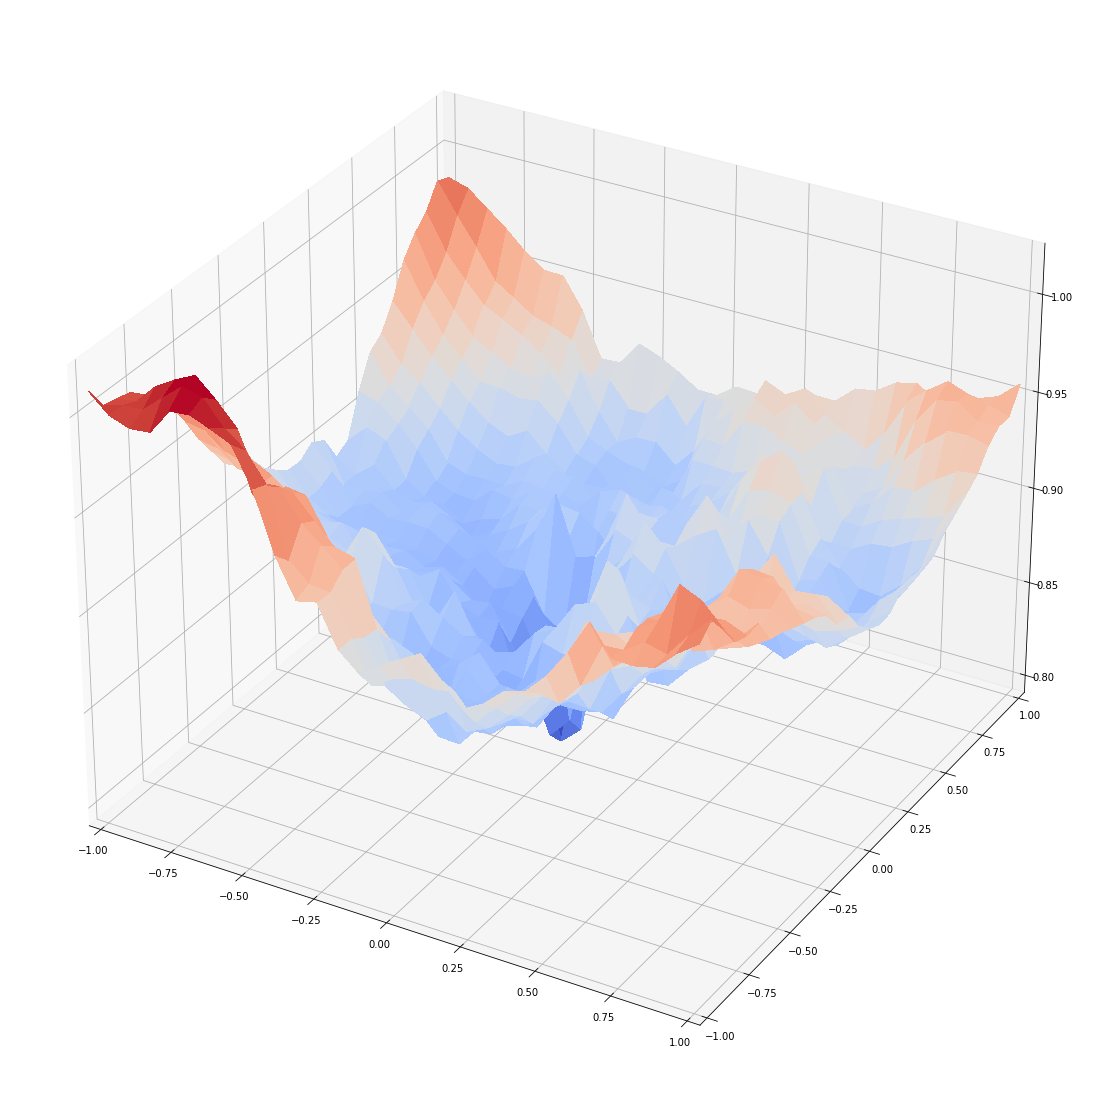

In [ ]:
generate_plots(file_name=PARTIAL_NAME, 
               with_axes=True,
               log=True)

<Figure size 1440x1440 with 0 Axes>

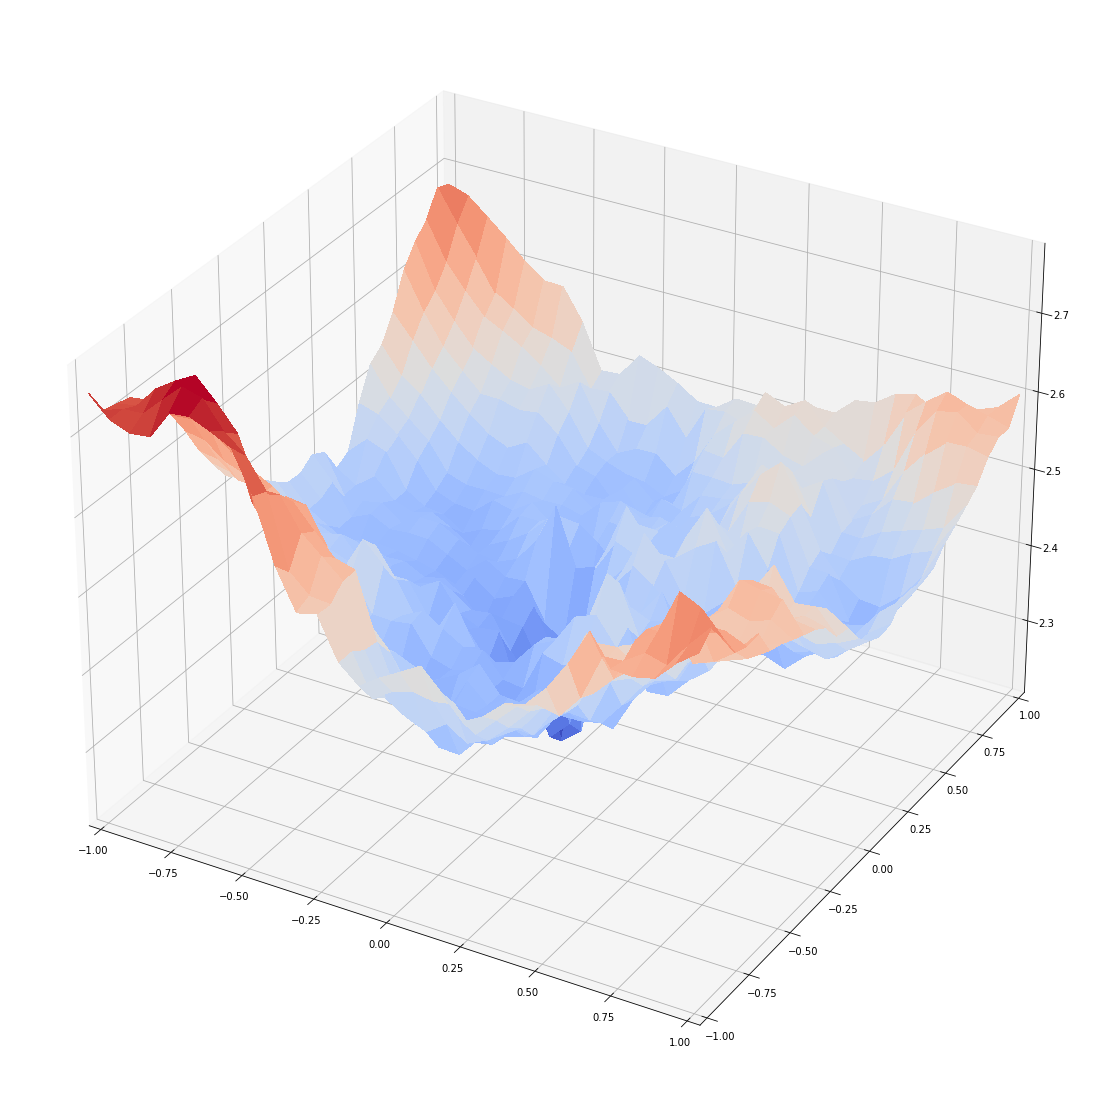

In [ ]:
generate_plots(file_name=PARTIAL_NAME, 
               with_axes=True,
               log=False)

What if I try to see how the loss landscape looks on the test data??